# DBLP Network Analysis: Collaboration, Communities, and Influence

**Team Member:** Ai Nhien To  
**Task:** Network Analysis (Citation & Co-authorship Graphs)  
**Date:** December 5, 2025

---

## Overview

This notebook performs comprehensive network analysis on the cleaned DBLP Parquet datasets:

- Build **citation** (directed) and **co-authorship** (undirected) graphs  
- Compute basic **graph statistics** (nodes, edges, density, components)  
- Compute **centrality metrics** (degree, PageRank, betweenness)  
- Detect **communities** (Louvain on co-authorship graph)  
- Explore **temporal evolution** based on publication year  
- Generate **summary tables and visualizations** for the final report

## 1. Setup and Imports

In [ ]:
# Standard library imports
import sys
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Add project root to Python path
project_root = Path("..").resolve()
sys.path.insert(0, str(project_root))

# Local imports
from src.networks.graph_builder import build_citation_graph, build_coauthorship_graph
from src.networks.metrics import calculate_centralities, get_graph_stats

# Configure plotting style
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

print("✓ All libraries imported successfully")

## 2. Data Loading

In [ ]:
# Define data directories
DATA_DIR = project_root / "data" / "parquet"
OUTPUT_DIR = project_root / "data" / "derived"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load parquet datasets
print("Loading datasets...")
papers = pd.read_parquet(DATA_DIR / "papers")
citations_df = pd.read_parquet(DATA_DIR / "citations")
coauthorships_df = pd.read_parquet(DATA_DIR / "coauthorships")
authorships = pd.read_parquet(DATA_DIR / "authorships")

# Display summary
print("\n" + "="*60)
print("DATA LOADING SUMMARY")
print("="*60)
print(f"Papers:         {papers.shape[0]:>8,} rows × {papers.shape[1]} columns")
print(f"Citations:      {citations_df.shape[0]:>8,} rows × {citations_df.shape[1]} columns")
print(f"Coauthorships:  {coauthorships_df.shape[0]:>8,} rows × {coauthorships_df.shape[1]} columns")
print(f"Authorships:    {authorships.shape[0]:>8,} rows × {authorships.shape[1]} columns")
print(f"\nOutput directory: {OUTPUT_DIR.resolve()}")
print("="*60)

Data loaded successfully:
  papers: (100000, 9)
  citations_df: (538071, 4)
  coauthorships_df: (393147, 5)
  authorships: (289513, 4)

Output directory: C:\Users\Frankinstyle\Data Science I\COSC-3337-Project\data\derived


## 3. Graph Construction

In [ ]:
# Build citation graph (directed)
print("Building citation graph (directed)...")
G_citation = build_citation_graph(citations_df)

# Build coauthorship graph (undirected)
print("Building coauthorship graph (undirected)...")
G_coauthor = build_coauthorship_graph(coauthorships_df)

# Compute graph statistics
print("\n" + "="*60)
print("CITATION GRAPH (Directed)")
print("="*60)
print(f"Nodes (papers):             {G_citation.number_of_nodes():>10,}")
print(f"Edges (citations):          {G_citation.number_of_edges():>10,}")
print(f"Density:                    {nx.density(G_citation):>14.6f}")

weakly_connected = list(nx.weakly_connected_components(G_citation))
largest_wcc = max(weakly_connected, key=len)
print(f"Weakly connected components:{len(weakly_connected):>10,}")
print(f"Largest WCC:                {len(largest_wcc):>10,} ({len(largest_wcc)/G_citation.number_of_nodes()*100:.1f}%)")

print("\n" + "="*60)
print("CO-AUTHORSHIP GRAPH (Undirected)")
print("="*60)
print(f"Nodes (authors):            {G_coauthor.number_of_nodes():>10,}")
print(f"Edges (collaborations):     {G_coauthor.number_of_edges():>10,}")
print(f"Density:                    {nx.density(G_coauthor):>14.6f}")

connected_comps = list(nx.connected_components(G_coauthor))
largest_cc = max(connected_comps, key=len)
print(f"Connected components:       {len(connected_comps):>10,}")
print(f"Largest CC:                 {len(largest_cc):>10,} ({len(largest_cc)/G_coauthor.number_of_nodes()*100:.1f}%)")
print("="*60)

Building citation graph...
Building coauthorship graph...

CITATION GRAPH (Directed)
Nodes (papers): 326,677
Edges (citations): 538,071
Density: 0.000005
Weakly connected components: 5244
Largest weakly connected component size: 308,358 (94.4%)

CO-AUTHORSHIP GRAPH (Undirected)
Nodes (authors): 162,695
Edges (collaborations): 346,661
Density: 0.000026
Connected components: 16364
Largest connected component size: 100,433 (61.7%)


## 4. Degree Distribution Analysis

### 4.1 Citation Graph Degree Distribution

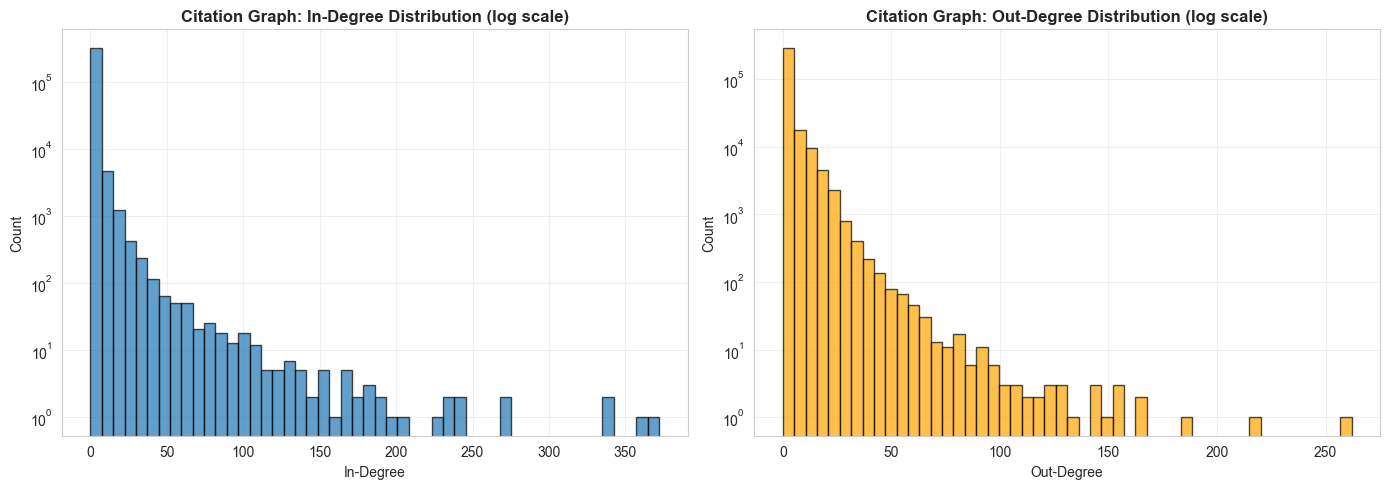

Citation Graph Degree Statistics:
  In-degree  - Mean: 1.65, Median: 1.00, Max: 372
  Out-degree - Mean: 1.65, Median: 0.00, Max: 262


In [ ]:
# Extract degree sequences
in_degrees = [d for _, d in G_citation.in_degree()]
out_degrees = [d for _, d in G_citation.out_degree()]

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# In-degree distribution
axes[0].hist(in_degrees, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_yscale('log')
axes[0].set_title('Citation Graph: In-Degree Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('In-Degree (Times Cited)')
axes[0].set_ylabel('Count (log scale)')
axes[0].grid(True, alpha=0.3)

# Out-degree distribution
axes[1].hist(out_degrees, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_yscale('log')
axes[1].set_title('Citation Graph: Out-Degree Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Out-Degree (References Made)')
axes[1].set_ylabel('Count (log scale)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("Citation Graph Degree Statistics:")
print(f"  In-degree  → Mean: {np.mean(in_degrees):.2f}, Median: {np.median(in_degrees):.2f}, Max: {np.max(in_degrees)}")
print(f"  Out-degree → Mean: {np.mean(out_degrees):.2f}, Median: {np.median(out_degrees):.2f}, Max: {np.max(out_degrees)}")

### 4.2 Co-authorship Graph Degree Distribution

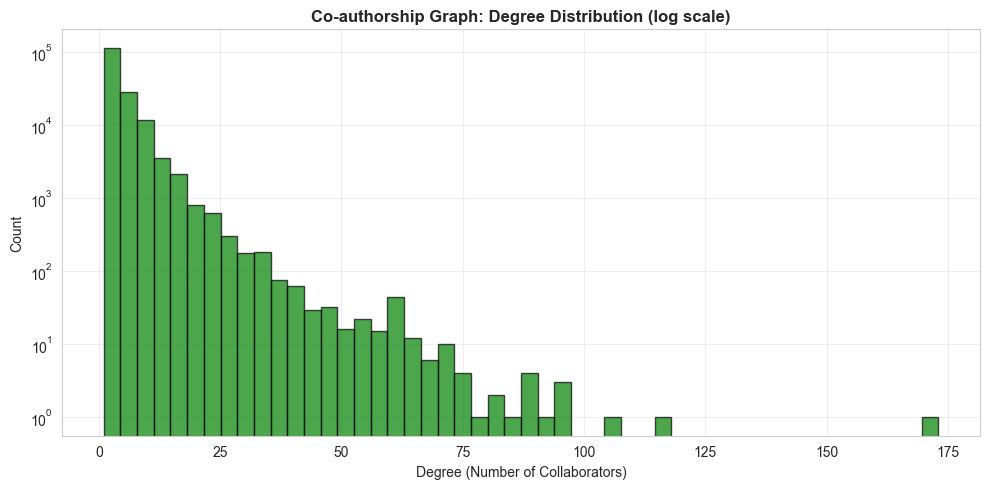

Co-authorship Graph Degree Statistics:
  Degree - Mean: 4.26, Median: 3.00, Max: 173


In [ ]:
# Extract degree sequence
co_degrees = [d for _, d in G_coauthor.degree()]

# Create visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(co_degrees, bins=50, edgecolor='black', alpha=0.7, color='green')
ax.set_yscale('log')
ax.set_title('Co-authorship Graph: Degree Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Degree (Number of Collaborators)')
ax.set_ylabel('Count (log scale)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print("Co-authorship Graph Degree Statistics:")
print(f"  Degree → Mean: {np.mean(co_degrees):.2f}, Median: {np.median(co_degrees):.2f}, Max: {np.max(co_degrees)}")

## 5. Centrality Metrics

### 5.1 Citation Graph Centrality

In [ ]:
# Compute centrality metrics for citation graph
print("Computing centrality metrics for citation graph...")
print("  → PageRank")
pagerank = nx.pagerank(G_citation)

print("  → Betweenness centrality (approximate with k=1000)")
betweenness_cit = nx.betweenness_centrality(G_citation, k=min(1000, G_citation.number_of_nodes()), seed=42)

# Extract degree dictionaries
in_deg = dict(G_citation.in_degree())
out_deg = dict(G_citation.out_degree())

# Build metrics dataframe
cit_metrics = pd.DataFrame({
    'paper_id': list(G_citation.nodes()),
    'in_degree': [in_deg.get(n, 0) for n in G_citation.nodes()],
    'out_degree': [out_deg.get(n, 0) for n in G_citation.nodes()],
    'pagerank': [pagerank.get(n, 0) for n in G_citation.nodes()],
    'betweenness': [betweenness_cit.get(n, 0) for n in G_citation.nodes()]
})

# Join with paper metadata
meta_cols = [col for col in ['id', 'title', 'year', 'venue'] if col in papers.columns]
cit_metrics = cit_metrics.merge(papers[meta_cols], left_on='paper_id', right_on='id', how='left')

# Check for papers not in our dataset
papers_in_dataset = cit_metrics['title'].notna().sum()
papers_missing = cit_metrics['title'].isna().sum()

print(f"\n✓ Citation metrics computed for {len(cit_metrics):,} papers")
print(f"  - Papers with metadata: {papers_in_dataset:,}")
print(f"  - Papers cited but not in dataset: {papers_missing:,}")
print(f"\nNote: Missing papers are cited works that aren't in our 100K sample.\n")

# Show top papers that EXIST in our dataset
print("Top 10 Papers by PageRank (from our dataset):")
top_papers_with_data = cit_metrics[cit_metrics['title'].notna()].nlargest(10, 'pagerank')
display(top_papers_with_data[['title', 'year', 'venue', 'in_degree', 'pagerank']])

Computing centrality metrics for citation graph...
  → PageRank (may take a few minutes)...
  → Betweenness centrality (approximate with k=1000)...

✓ Citation metrics computed for 326,677 papers
  - Papers with metadata: 62,980
  - Papers cited but not in dataset: 263,697

Note: Missing papers are cited works that aren't in our 100K sample.

Top 10 Papers by PageRank (from our dataset):


,title,year,venue,in_degree,pagerank
655,A framework and graphical development environm...,2002.0,meeting of the association for computational l...,51,0.000025
4510,A Spatial Logic based on Regions and Connection.,1992.0,principles of knowledge representation and rea...,59,0.000020
22797,DBpedia: a nucleus for a web of open data,2007.0,international semantic web conference,47,0.000014
3601,"UCPOP: A Sound, Complete, Partial Order Planne...",1992.0,principles of knowledge representation and rea...,27,0.000011
19474,Finite state morphology,2003.0,,8,0.000011
23329,Comparison of background normalization methods...,1997.0,,9,0.000010
30324,"Workflow Management: Modeling Concepts, Archit...",1996.0,,11,0.000010
18557,A portable dextrous master with force feedback,1992.0,Presence: Teleoperators & Virtual Environments,5,0.000009
2833,Pushing the EL envelope,2005.0,international joint conference on artificial i...,29,0.000009
219508,From switchboard to fisher: telephone collecti...,2003.0,conference of the international speech communi...,3,0.000008


### 5.2 Co-authorship Graph Centrality

In [ ]:
# Compute centrality metrics for co-authorship graph
print("Computing centrality metrics for co-authorship graph...")
print("  → Degree centrality...")
degree_co = dict(G_coauthor.degree())

print("  → Betweenness centrality (approximate with k=1000)...")
betweenness_co = nx.betweenness_centrality(G_coauthor, k=min(1000, G_coauthor.number_of_nodes()), seed=42)

# Build metrics dataframe
co_metrics = pd.DataFrame({
    'author_norm': list(G_coauthor.nodes()),
    'degree': [degree_co.get(n, 0) for n in G_coauthor.nodes()],
    'betweenness': [betweenness_co.get(n, 0) for n in G_coauthor.nodes()]
})

print(f"\n✓ Co-authorship metrics computed for {len(co_metrics):,} authors\n")
print("Top 10 Authors by Degree (Most Collaborators):")
display(co_metrics.nlargest(10, 'degree')[['author_norm', 'degree', 'betweenness']])

Computing centrality metrics for co-authorship graph...
  - Degree centrality...
  - Betweenness centrality (approximate with k=1000)...

Co-authorship metrics computed for 162695 authors

Top 10 authors by degree (most collaborators):


,author_norm,degree,betweenness
111,br,173,0.005789
7187,wei wang,115,0.015840
614,lei zhang,105,0.008541
4248,norbert fuhr,96,0.004711
5471,helmut krcmar,96,0.004221
3160,gareth jones,94,0.005401
2447,henning muller,92,0.002505
732,mario piattini,90,0.005886
360,wei liu,87,0.002277
11742,sascha kriewel,87,0.001918


## 6. Community Detection (Louvain Algorithm)

In [ ]:
# Apply Louvain community detection
print("Running Louvain community detection on co-authorship graph...")
try:
    import community as community_louvain
except ImportError:
    print("Installing python-louvain...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'python-louvain'])
    import community as community_louvain

partition = community_louvain.best_partition(G_coauthor)

# Create community dataframe
co_communities = pd.DataFrame({
    'author_norm': list(partition.keys()),
    'community': list(partition.values())
})

# Merge with centrality metrics
co_full = co_metrics.merge(co_communities, on='author_norm', how='left')

print(f"\n✓ Communities detected: {len(set(partition.values())):,}\n")
print("Top 10 Communities by Size:")
community_sizes = co_full['community'].value_counts().head(10)
display(community_sizes)

print("\nCommunity-Level Statistics (Top 10 by Size):")
community_stats = co_full.groupby('community').agg({
    'degree': ['count', 'mean', 'max'],
    'betweenness': ['mean', 'max']
}).sort_values(('degree', 'count'), ascending=False).head(10)
display(community_stats)

Running Louvain community detection on co-authorship graph...

Communities detected: 16539

Top 10 communities by size:


community
51     3252
4      2641
3      2432
21     2332
0      2144
123    1503
61     1487
377    1447
179    1434
663    1263
Name: count, dtype: int64


Community-level statistics (top 10 by size):


degree                betweenness          
           count      mean  max        mean       max
community                                            
51          3252  4.823801   96    0.000036  0.005041
4           2641  5.580462   62    0.000055  0.004220
3           2432  5.565789   73    0.000028  0.002697
21          2332  5.675815   59    0.000042  0.004476
0           2144  5.464086   68    0.000030  0.004260
123         1503  5.230206   55    0.000051  0.005062
61          1487  4.658373   47    0.000033  0.002536
377         1447  4.234278   43    0.000028  0.002214
179         1434  4.861925   39    0.000029  0.002608
663         1263  4.856690  173    0.000029  0.005789

## 7. Temporal Analysis

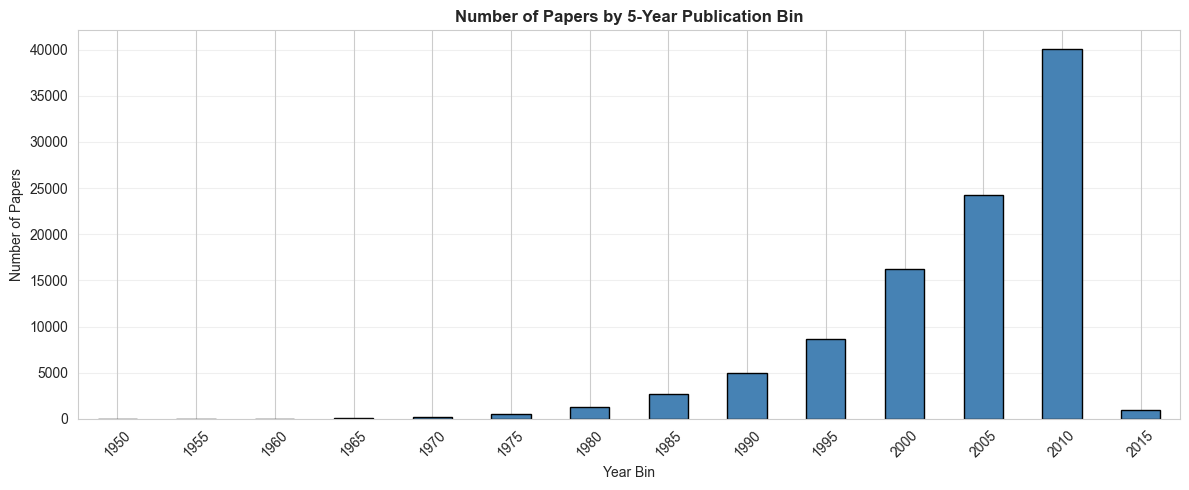

Paper distribution by 5-year bin:


year_bin
1950        1
1955        6
1960       14
1965       48
1970      216
1975      513
1980     1259
1985     2653
1990     5024
1995     8688
2000    16229
2005    24291
2010    40075
2015      983
Name: count, dtype: int64

In [ ]:
# Analyze publication trends over time
if 'year' in papers.columns:
    # Create 5-year bins
    papers['year_bin'] = (papers['year'] // 5) * 5
    
    # Visualize publication trends
    fig, ax = plt.subplots(figsize=(12, 5))
    papers['year_bin'].value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
    ax.set_title('Publication Volume by 5-Year Bins', fontsize=12, fontweight='bold')
    ax.set_xlabel('Year Bin')
    ax.set_ylabel('Number of Papers')
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print("Publication Distribution by 5-Year Bin:")
    display(papers['year_bin'].value_counts().sort_index())
else:
    print("WARNING: 'year' column not found in papers table")

## 8. Network Visualization

Citation subgraph (top 100 by PageRank):
  Nodes: 100
  Edges: 0


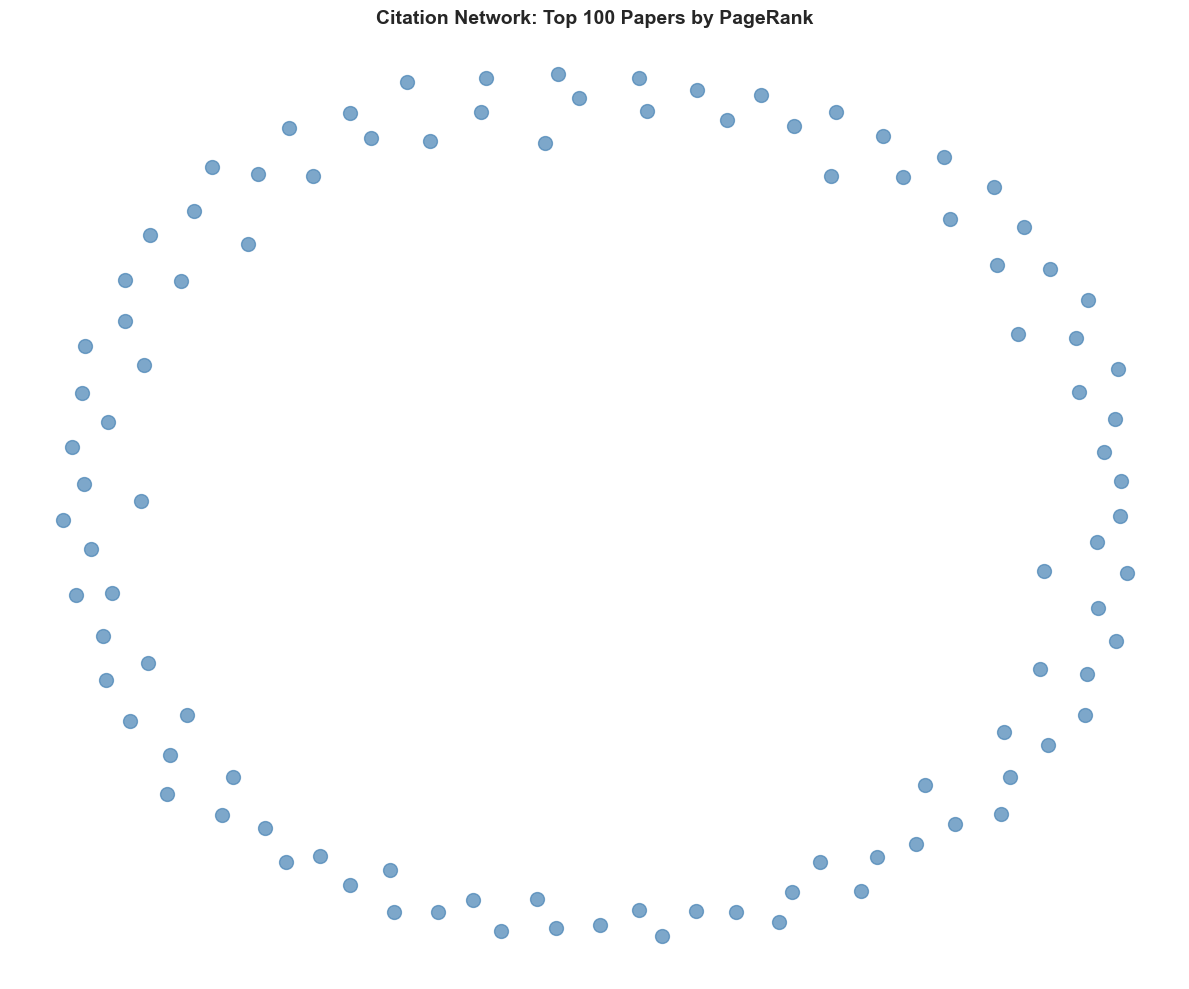

In [ ]:
# Visualize citation subgraph: top papers by PageRank
TOP_K = 100
top_papers = cit_metrics.nlargest(TOP_K, 'pagerank')['paper_id'].tolist()
subgraph = G_citation.subgraph(top_papers)

print(f"Citation Subgraph (Top {TOP_K} Papers by PageRank):")
print(f"  Nodes: {subgraph.number_of_nodes():,}")
print(f"  Edges: {subgraph.number_of_edges():,}\n")

# Generate spring layout
pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 10))
nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color='steelblue', alpha=0.7, ax=ax)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.2, ax=ax, width=0.5)
ax.set_title(f'Citation Network: Top {TOP_K} Papers by PageRank', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

## 9. Export Results

In [ ]:
# Export network metrics and community assignments
print("Exporting network analysis results...\n")

# Save citation metrics
cit_metrics.to_csv(OUTPUT_DIR / 'citation_centrality_metrics.csv', index=False)
print(f"✓ Citation metrics saved:")
print(f"  {(OUTPUT_DIR / 'citation_centrality_metrics.csv').resolve()}")

# Save co-authorship metrics with communities
co_full.to_csv(OUTPUT_DIR / 'coauthor_centrality_communities.csv', index=False)
print(f"\n✓ Co-authorship metrics saved:")
print(f"  {(OUTPUT_DIR / 'coauthor_centrality_communities.csv').resolve()}")

# Create summary report
summary_report = {
    'Citation Graph': {
        'Nodes (Papers)': f"{G_citation.number_of_nodes():,}",
        'Edges (Citations)': f"{G_citation.number_of_edges():,}",
        'Density': f"{nx.density(G_citation):.6f}",
        'Weakly Connected Components': len(weakly_connected),
        'Largest WCC Size': f"{len(largest_wcc):,} ({len(largest_wcc)/G_citation.number_of_nodes()*100:.1f}%)"
    },
    'Co-authorship Graph': {
        'Nodes (Authors)': f"{G_coauthor.number_of_nodes():,}",
        'Edges (Collaborations)': f"{G_coauthor.number_of_edges():,}",
        'Density': f"{nx.density(G_coauthor):.6f}",
        'Connected Components': len(connected_comps),
        'Largest CC Size': f"{len(largest_cc):,} ({len(largest_cc)/G_coauthor.number_of_nodes()*100:.1f}%)",
        'Communities (Louvain)': len(set(partition.values()))
    }
}

summary_df = pd.DataFrame(summary_report).T
print("\n" + "="*60)
print("NETWORK ANALYSIS SUMMARY")
print("="*60)
display(summary_df)
print("="*60)

Exporting network analysis results...
✓ Saved: C:\Users\Frankinstyle\Data Science I\COSC-3337-Project\data\derived\citation_centrality_metrics.csv
✓ Saved: C:\Users\Frankinstyle\Data Science I\COSC-3337-Project\data\derived\coauthor_centrality_communities.csv

NETWORK ANALYSIS SUMMARY


,Nodes (Papers),Edges (Citations),Density,Weakly Connected Components,Largest WCC Size,Nodes (Authors),Edges (Collaborations),Connected Components,Largest CC Size,Communities (Louvain)
Citation Graph,"326,677","538,071",0.000005,5244,"308,358 (94.4%)",NaN,NaN,NaN,NaN,NaN
Co-authorship Graph,NaN,NaN,0.000026,NaN,NaN,"162,695","346,661",16364,"100,433 (61.7%)",16539
